In [1]:
## Set-up.
### Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
! pip freeze > '../requirements.txt'

In [3]:
DATA_PATH = '../dataset/'

In [4]:
data = pd.read_parquet(os.path.join(DATA_PATH,'data_eng.gzip'))

In [5]:
data.head()

,age,gender,education,class,marital_status,race,is_hispanic,employment_commitment,employment_stat,wage_per_hour,working_week_per_year,industry_code_main,occupation_code_main,household_summary,vet_benefit,tax_status,citizenship,income_above_limit,investments
0,63+,Female,highschool,NA,Widowed,White,No,Unemployed,0,0_10,weeks_worked_48_52,Not in universe or children,NA,Householder,2,Head of household,Native,0,True
1,63+,Female,highschool,NA,Widowed,White,No,Children or Armed Forces,0,0_10,weeks_worked_0,Not in universe or children,NA,Householder,2,Single,Native,0,False
2,18_24,Male,no_highschool,Federal government,Never married,Black,No,Children or Armed Forces,0,101_500,weeks_worked_1_25,Hospital services,Adm support including clerical,Child 18 or older,2,Single,Native,0,False
4,63+,Male,highschool,NA,Married-civilian spouse present,White,No,Unemployed,0,0_10,weeks_worked_0,Not in universe or children,NA,Spouse of householder,2,Joint both 65+,Native,0,False
5,33_45,Male,bachelors,Private,Married-civilian spouse present,Asian or Pacific Islander,No,Children or Armed Forces,0,501_1000,weeks_worked_48_52,Retail trade,Other service,Householder,2,Joint both under 65,Foreign born- Not a citizen of U S,0,False


In [6]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('income_above_limit', axis=1), data['income_above_limit'], test_size=0.3, random_state=12345)

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor = Pipeline(
    steps=[
        ('impute',SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown="ignore"))
        ]
)

In [9]:
X_tr_pr = preprocessor.fit_transform(X_train)

In [10]:
X_tst_pr = preprocessor.transform(X_test)

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score as ROC

def dmp_first_classifier(model, train_x, train_y, test_x, test_y, parameters ={}):
    classifier = model()
    if len(parameters.items())>0:
        searcher = GridSearchCV(classifier, parameters, cv=5)
        searcher.fit(train_x, train_y)
        print(f'Model {model}')
        print("Best CV params", searcher.best_params_)
        #print("Test accuracy of best grid search hypers:", searcher.score(test_x, test_y))
        best_model = searcher.best_estimator_
    else: best_model = classifier
    best_model.fit(train_x, train_y)
    print("Test accuracy of best grid search hypers:", best_model.score(test_x, test_y))
    return best_model

def train_accuracy(model, train_x, train_y, test_x, test_y):
    model.fit(train_x, train_y)
    print("Test accuracy:", model.score(test_x, test_y))
    return model

In [21]:
from sklearn.linear_model import LogisticRegression
lrg = LogisticRegression
parameters = {'C':[0.01,0.1,1]}
best_lrg = dmp_first_classifier(lrg, X_tr_pr, y_train, X_tst_pr, y_test, parameters)

Model <class 'sklearn.linear_model._logistic.LogisticRegression'>
Best CV params {'C': 0.1}
Test accuracy of best grid search hypers: 0.9309979237531475


In [22]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier
parameters = {'n_neighbors':[5,10,50]}
best_knc = dmp_first_classifier(knc, X_tr_pr, y_train, X_tst_pr, y_test, parameters)

Model <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Best CV params {'n_neighbors': 50}
Test accuracy of best grid search hypers: 0.9288112382382825


In [23]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier
parameters = {'n_estimators':[100,50], 'min_samples_leaf':[1,5,10,20]}
best_rfc = dmp_first_classifier(rfc, X_tr_pr, y_train, X_tst_pr, y_test, parameters)

Model <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Best CV params {'min_samples_leaf': 5, 'n_estimators': 50}
Test accuracy of best grid search hypers: 0.9310420992180942


In [50]:
from sklearn.linear_model import SGDClassifier
sgdc = SGDClassifier
parameters = {'loss':['hinge','log_loss']}
best_sgdc = dmp_first_classifier(sgdc, X_tr_pr, y_train, X_tst_pr, y_test, parameters)


Model <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>
Best CV params {'loss': 'log_loss'}
Test accuracy of best grid search hypers: 0.9313292397402483


In [29]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier
parameters = {'learning_rate':[0.01,0.1,1], 'n_estimators':[100,50], 'min_samples_leaf':[1,5,10,20]}
best_gbc = dmp_first_classifier(gbc, X_tr_pr, y_train, X_tst_pr, y_test, parameters)

Model <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
Best CV params {'learning_rate': 0.1, 'min_samples_leaf': 10, 'n_estimators': 100}
Test accuracy of best grid search hypers: 0.9310200114856209


In [30]:
import xgboost as xgb
xgbc = xgb.XGBClassifier
parameters = {'eta':[0.1,0.3,0.5,1],'max_depth':[3,6,10]}
best_xgbc = dmp_first_classifier(xgbc, X_tr_pr, y_train, X_tst_pr, y_test, parameters)


Model <class 'xgboost.sklearn.XGBClassifier'>
Best CV params {'eta': 0.1, 'max_depth': 6}
Test accuracy of best grid search hypers: 0.9325661527587578


### Score TOP-3

In [32]:
from sklearn import metrics

def score_model(model, X, y):
    predicted = model.predict(X)
    probs = model.predict_proba(X)
    
    # Generate and display different evaluation metrics
    print(metrics.accuracy_score(y, predicted))
    print(metrics.roc_auc_score(y, probs[:, 1]))
    
    print(metrics.confusion_matrix(y, predicted))
    print(metrics.classification_report(y, predicted))

In [33]:
score_model(best_xgbc, X_tst_pr, y_test)

0.9325661527587578
0.9167021727191886
[[40820   611]
 [ 2442  1401]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     41431
           1       0.70      0.36      0.48      3843

    accuracy                           0.93     45274
   macro avg       0.82      0.67      0.72     45274
weighted avg       0.92      0.93      0.92     45274


In [51]:
score_model(best_sgdc, X_tst_pr, y_test)

0.9313292397402483
0.913067048836337
[[40772   659]
 [ 2450  1393]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     41431
           1       0.68      0.36      0.47      3843

    accuracy                           0.93     45274
   macro avg       0.81      0.67      0.72     45274
weighted avg       0.92      0.93      0.92     45274


In [35]:
score_model(best_rfc, X_tst_pr, y_test)

0.9310420992180942
0.9121019775908745
[[41000   431]
 [ 2691  1152]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     41431
           1       0.73      0.30      0.42      3843

    accuracy                           0.93     45274
   macro avg       0.83      0.64      0.69     45274
weighted avg       0.92      0.93      0.92     45274


## Plus clusters

In [36]:
from kmodes.kmodes import KModes

In [37]:
clusters_prepr = KModes(n_clusters = 4, init='Huang',n_jobs=-1,n_init=10,verbose=1)
clusters_prepr.fit(X_train)

Best run was number 10


KModes(init='Huang', n_clusters=4, n_jobs=-1, verbose=1)

In [38]:
X_train_cl = X_train.copy()
X_train_cl['Cluster'] = clusters_prepr.labels_

In [39]:
X_test_cl = X_test.copy()
X_test_cl['Cluster']=clusters_prepr.predict(X_test)

In [40]:
X_train_cl_pr = preprocessor.fit_transform(X_train_cl)

In [41]:
X_test_cl_pr = preprocessor.transform(X_test_cl)

In [42]:
from sklearn.base import clone

In [57]:
sgdc = clone(best_sgdc)
best_sgdc_cl = train_accuracy(sgdc, X_train_cl_pr, y_train, X_test_cl_pr, y_test)

Test accuracy: 0.9311525378804612


In [54]:
xgbc = clone(best_xgbc)
best_xgbc_cl = train_accuracy(xgbc, X_train_cl_pr, y_train, X_test_cl_pr, y_test)

Test accuracy: 0.9322127490391836


In [45]:
rfc = clone(best_rfc)
best_rfc_cl = train_accuracy(rfc, X_train_cl_pr, y_train, X_test_cl_pr, y_test)

Test accuracy: 0.9302027653841056


In [47]:
score_model(best_xgbc_cl, X_test_cl_pr, y_test)


0.9322127490391836
0.9166875733614586
[[40807   624]
 [ 2445  1398]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     41431
           1       0.69      0.36      0.48      3843

    accuracy                           0.93     45274
   macro avg       0.82      0.67      0.72     45274
weighted avg       0.92      0.93      0.92     45274


In [58]:
score_model(best_sgdc_cl, X_test_cl_pr, y_test)

0.9311525378804612
0.9140724104151347
[[40603   828]
 [ 2289  1554]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     41431
           1       0.65      0.40      0.50      3843

    accuracy                           0.93     45274
   macro avg       0.80      0.69      0.73     45274
weighted avg       0.92      0.93      0.92     45274


In [49]:
score_model(best_rfc_cl, X_test_cl_pr, y_test)

0.9302027653841056
0.9118682339914086
[[40980   451]
 [ 2709  1134]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     41431
           1       0.72      0.30      0.42      3843

    accuracy                           0.93     45274
   macro avg       0.83      0.64      0.69     45274
weighted avg       0.92      0.93      0.92     45274


## Clusters  decrease performance of XGBoost, SGD and RandomForest

## Upsampling

In [59]:
upsample_training = X_train.copy()
upsample_training['Y'] = y_train

In [60]:
bellow = upsample_training.loc[upsample_training.Y==0]
above = upsample_training.loc[upsample_training.Y==1]

In [61]:
from sklearn.utils import resample
above_upsample = resample(above,
             replace=True,
             n_samples=len(bellow),
             random_state=12345)

In [62]:
print(bellow.shape)
print(above_upsample.shape)

(96485, 19)
(96485, 19)


In [63]:
data_upsample = pd.concat([bellow, above_upsample])
data_upsample.head()

,age,gender,education,class,marital_status,race,is_hispanic,employment_commitment,employment_stat,wage_per_hour,working_week_per_year,industry_code_main,occupation_code_main,household_summary,vet_benefit,tax_status,citizenship,investments,Y
87286,63+,Female,masters,NA,Never married,White,No,Children or Armed Forces,0,0_10,weeks_worked_0,Not in universe or children,NA,Householder,2,Single,Native,False,0
78624,46_62,Female,highschool,NA,Married-civilian spouse present,White,No,Children or Armed Forces,0,0_10,weeks_worked_0,Not in universe or children,NA,Spouse of householder,2,Joint one under 65 & one 65+,Native,False,0
2842,63+,Male,no_highschool,NA,Married-civilian spouse present,White,No,Unemployed,0,0_10,weeks_worked_0,Not in universe or children,NA,Householder,2,Joint both 65+,Native,False,0
88532,46_62,Female,highschool,Private,Never married,White,No,Full-time schedules,2,0_10,weeks_worked_48_52,Retail trade,Adm support including clerical,Child 18 or older,2,Single,Native,False,0
10009,46_62,Female,somecollege,Private,Divorced,White,No,Children or Armed Forces,0,0_10,weeks_worked_48_52,Social services,Professional specialty,Householder,2,Head of household,Native,False,0


In [64]:
X_train_up = data_upsample.drop('Y', axis=1)
y_train_up = data_upsample.Y

In [72]:
X_train_up_pr = preprocessor.fit_transform(X_train_up)
X_tst_up_pr = preprocessor.transform(X_test)

In [73]:
from sklearn.linear_model import LogisticRegression
lrg = LogisticRegression
parameters = {'C':[0.01,0.1,1]}
best_lrg_up = dmp_first_classifier(lrg, X_train_up_pr, y_train_up, X_tst_up_pr, y_test, parameters)

Model <class 'sklearn.linear_model._logistic.LogisticRegression'>
Best CV params {'C': 1}
Test accuracy of best grid search hypers: 0.8299907231523612


In [74]:
import xgboost as xgb
xgbc = xgb.XGBClassifier
parameters = {'eta':[0.1,0.3,0.5,1],'max_depth':[3,6,10]}
best_xgbc_up = dmp_first_classifier(xgbc, X_train_up_pr, y_train_up, X_tst_up_pr, y_test, parameters)

Model <class 'xgboost.sklearn.XGBClassifier'>
Best CV params {'eta': 1, 'max_depth': 10}
Test accuracy of best grid search hypers: 0.8862923532270177


In [68]:
from sklearn.linear_model import SGDClassifier
sgdc = SGDClassifier
parameters = {'loss':['hinge','log_loss']}
best_sgdc_up = dmp_first_classifier(sgdc, X_train_up_pr, y_train_up, X_tst_up_pr, y_test, parameters)


Model <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>
Best CV params {'loss': 'log_loss'}
Test accuracy of best grid search hypers: 0.8515041745814375


In [75]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier
parameters = {'n_estimators':[100,50], 'min_samples_leaf':[1,5,10,20]}
best_rfc_up = dmp_first_classifier(rfc, X_train_up_pr, y_train_up, X_tst_up_pr, y_test, parameters)

Model <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Best CV params {'min_samples_leaf': 1, 'n_estimators': 100}
Test accuracy of best grid search hypers: 0.8989486239342669


In [76]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier
parameters = {'n_neighbors':[5,10,50]}
best_knc_up = dmp_first_classifier(knc, X_train_up_pr, y_train_up, X_tst_up_pr, y_test, parameters)

Model <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Best CV params {'n_neighbors': 5}
Test accuracy of best grid search hypers: 0.9057295578035959


## The best models

In [77]:
score_model(best_knc_up, X_tst_up_pr, y_test)

0.9057295578035959
0.7046862424678038
[[39544  1887]
 [ 2381  1462]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     41431
           1       0.44      0.38      0.41      3843

    accuracy                           0.91     45274
   macro avg       0.69      0.67      0.68     45274
weighted avg       0.90      0.91      0.90     45274


## ! High accurasy but aweful AUC_Curve

In [80]:
score_model(best_rfc_up, X_tst_up_pr, y_test)

0.8989486239342669
0.8709298637747716
[[38721  2710]
 [ 1865  1978]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94     41431
           1       0.42      0.51      0.46      3843

    accuracy                           0.90     45274
   macro avg       0.69      0.72      0.70     45274
weighted avg       0.91      0.90      0.90     45274


In [90]:
score_model(best_xgbc_up, X_tst_pr, y_test)

0.8862923532270177
0.864908522132799
[[37900  3531]
 [ 1617  2226]]
              precision    recall  f1-score   support

           0       0.96      0.91      0.94     41431
           1       0.39      0.58      0.46      3843

    accuracy                           0.89     45274
   macro avg       0.67      0.75      0.70     45274
weighted avg       0.91      0.89      0.90     45274


## Compair with best models without upscaling

In [82]:
score_model(best_xgbc, X_tst_pr, y_test)

0.9325661527587578
0.9167021727191886
[[40820   611]
 [ 2442  1401]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     41431
           1       0.70      0.36      0.48      3843

    accuracy                           0.93     45274
   macro avg       0.82      0.67      0.72     45274
weighted avg       0.92      0.93      0.92     45274


In [83]:
score_model(best_sgdc, X_tst_pr, y_test)

0.9313292397402483
0.913067048836337
[[40772   659]
 [ 2450  1393]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     41431
           1       0.68      0.36      0.47      3843

    accuracy                           0.93     45274
   macro avg       0.81      0.67      0.72     45274
weighted avg       0.92      0.93      0.92     45274


In [84]:
import pickle
# save the model to disk
filename = 'res_model_rfc_up.pkl'
pickle.dump(best_rfc_up, open(filename, 'wb'))

In [85]:
# save the model to disk
filename = 'res_model_xgbc.pkl'
pickle.dump(best_xgbc, open(filename, 'wb'))

In [86]:
y_score = best_xgbc.predict_proba(X_tst_pr)

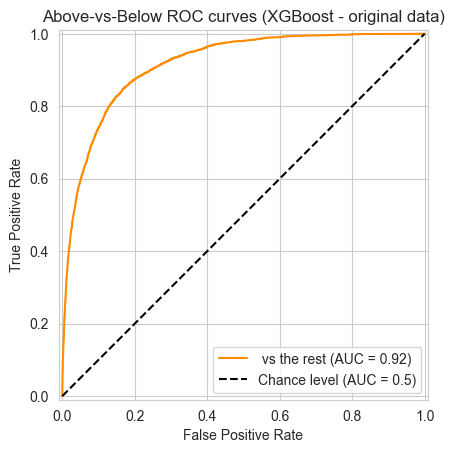

In [87]:
from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_predictions(
    y_test[:],
    y_score[:,1],
    name=f" vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Above-vs-Below ROC curves (XGBoost - original data)",
)

In [88]:
y_score_up = best_rfc_up.predict_proba(X_tst_up_pr)

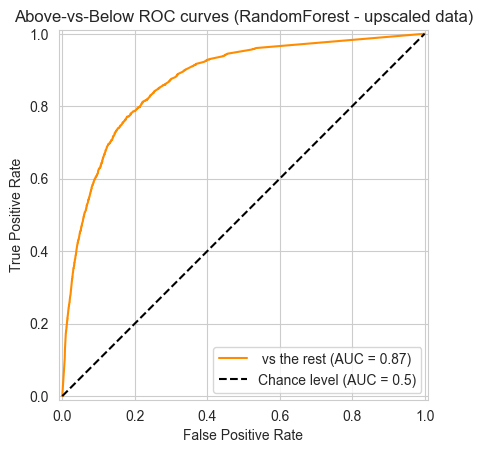

In [89]:
display = RocCurveDisplay.from_predictions(
    y_test[:],
    y_score_up[:,1],
    name=f" vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Above-vs-Below ROC curves (RandomForest - upscaled data)",
)